In [1]:
import time
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
plt.ion()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from fast_ml import eda

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
cudnn.benchmark=True

In [2]:
def dataprep(base_path, train_size, valid_size, test_size):

    df=pd.read_csv('{}/_converted.csv'.format(base_path))
    df['png_file']=df['png_file'].str.replace('.',base_path, 1, regex=True)
    #__read pdf file with pngs and create a dictionary to one hot encode
    data=df[['png_file', arg]]
    un_values=data[arg].unique()
    un_label=pd.factorize(un_values)
    class_map=dict(zip(un_label[1],un_label[0]))
    #__create samlple based on train, validation and test sizes given in main function
    size=train_size+valid_size+test_size
    data=data.sample(frac=1)
    
    train=pd.DataFrame()
    valid=pd.DataFrame()
    test=pd.DataFrame()

    for i in class_map:
        subset=data[data[arg]==i].reset_index(drop=True)
        train=pd.concat([train,subset[0:train_size]], ignore_index=True) 
        valid=pd.concat([valid,subset[train_size:train_size+valid_size]], ignore_index=True)
        test=pd.concat([test, subset[train_size+valid_size:size]], ignore_index=True)
        
    train=train.sample(frac=1).reset_index(drop=True)
    valid=valid.sample(frac=1).reset_index(drop=True)
    test=test.sample(frac=1).reset_index(drop=True)    
    return train, valid, test, class_map

In [3]:
class dog_brain_data(Dataset):
    def __init__(self, dataframe, transform=transforms.Compose([transforms.Resize((500,500))])):
        self.dataframe = dataframe
        self.transform = transform
        self.class_map=class_map
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        row=self.dataframe.iloc[index]
        image=read_image(row[0])
        label=row[1]
        label=self.class_map[label]
        
        if self.transform:
            image=self.transform(image)
            
        return image, label

In [4]:
def convert_to_tensor(train, valid, test, batch_size):
    global train_data, test_data, valid_data
    global train_loader, test_loader, valid_loader
    global dataloaders
    
    train_data=dog_brain_data(train)
    test_data=dog_brain_data(test)
    valid_data=dog_brain_data(valid)

    train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
    test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)
    valid_loader=torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=0)

    dataloaders = {'train': train_loader, 'valid':valid_loader}

In [5]:
def visualize_batch():
    inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    im_show(out, title=[class_map_inv[int(x)] for x in classes])

In [6]:
def im_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
def visualize_predictions(model, num_images=6):
    was_training = model.training
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    model=model.to(device)
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    correct=0
    total=0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            

            for j in range(inputs.size()[0]):
                predicted=(class_map_inv[int(preds[j])])
                actual=(class_map_inv[int(labels[j])])
                # print("predicted: {}, actual: {}".format(predicted, actual))
                
    
                images_so_far += 1
                ax = plt.subplot(num_images, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {(class_map_inv[int(preds[j])])}, actual: {(class_map_inv[int(labels[j])])}')
                im_show(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def evaluate_model(model, device):
    model=model.to(device)
    model.eval()
    predicted=[]
    actual=[]
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                predicted.append(class_map_inv[int(preds[j])])
                actual.append(class_map_inv[int(labels[j])])
        
        
        cm=confusion_matrix(actual, predicted)
        class_report=classification_report(actual, predicted, target_names=list(class_map.keys()))
        # accuracy = np.trace(cm) / np.sum(cm).astype('float')
        
    return cm, class_report

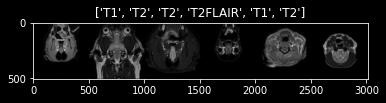

In [9]:
if __name__ == "__main__":
    
    
    
    #__log experiment in mlflow__#
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    #___data prep___#
    base_path='c:/Users/konstantin.moeller/python/ki_in_mrt'
    arg='scan_art'
    train_size=800
    valid_size=200
    test_size=200
    #__check if number of training, test and valid is possible for dataset
        
    train, valid, test, class_map=dataprep(base_path, train_size, valid_size, test_size)
    class_map_inv = {v: k for k, v in class_map.items()}
    batch_size=6
    convert_to_tensor(train, valid, test, batch_size)
    
    visualize_batch()

In [10]:
model=torch.load('{}/model/resnet_50'.format(base_path))

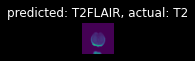

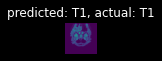

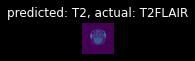

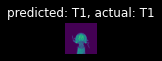

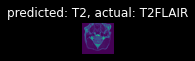

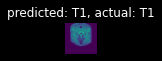

In [11]:
visualize_predictions(model, num_images=6)

In [12]:
cm, class_report=evaluate_model(model, device)

In [22]:
print(class_report)

              precision    recall  f1-score   support

          T1       0.96      0.94      0.95       200
     T2FLAIR       0.32      0.46      0.38       200
          T2       0.08      0.05      0.06       200

    accuracy                           0.48       600
   macro avg       0.46      0.48      0.46       600
weighted avg       0.46      0.48      0.46       600



In [14]:
class_map_inv

{0: 'T1', 1: 'T2FLAIR', 2: 'T2'}

In [23]:
def plot_confusion_matrix(cm,
                          target_names=list(class_map.keys()),
                          title='Confusion matrix',
                          cmap=plt.get_cmap('Blues'),
                          normalize=False):

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

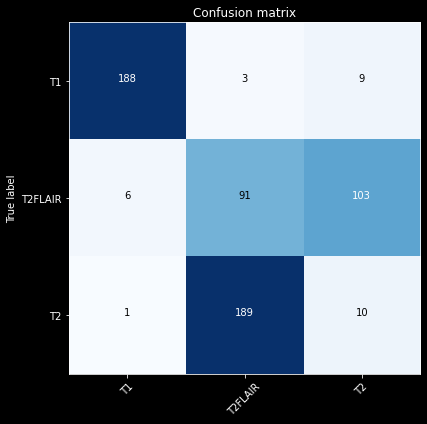

In [25]:
plot_confusion_matrix(cm)